In [12]:
import sys
print(sys.executable)


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/bin/python


# Zwei‑Stufen‑Modell mit XGBoost für EURUSD‑News

In diesem Notebook trainiere ich ein **Zwei‑Stufen‑Modell**, das aus News‑Features und Kursmerkmalen ableitet,

1. **Signal**: Gibt es eine signifikante Bewegung (`move`) oder bleibt der Kurs neutral?
2. **Richtung**: Wenn es eine Bewegung gibt – ist sie `up` oder `down`?

Die Labels wurden wie folgt definiert:

- Horizont: `horizon_days = 4` (Tage `t` bis `t+4`).
- Schwellen:
  - `up`: Lookahead‑Return `>= +1%`
  - `down`: Lookahead‑Return `<= −1%`
- Pfadbedingung: Streng monoton
  - `up`: `C_{t+1} > C_t`, `C_{t+2} > C_{t+1}`, `C_{t+3} > C_{t+2}`, `C_{t+4} > C_{t+3}`
  - `down`: entsprechend streng fallend.
- Alle übrigen Fälle werden als `neutral` gelabelt.

Aus diesen Labels wurden im Trainingsdatensatz zwei Zielvariablen abgeleitet:

- `signal`:
  - 0 = neutral
  - 1 = Bewegung (up oder down)
- `direction`:
  - 0 = down
  - 1 = up
  - NaN = neutral (wird für das Richtungs‑Modell ignoriert)

**XGBoost‑Modelle (Default‑Parameter in diesem Notebook)**

- Allgemein:
  - `max_depth = 3`
  - `learning_rate = 0.05`
  - `n_estimators = 400`
  - `subsample = 0.9`
  - `colsample_bytree = 0.9`
  - `random_state = 42`
  - `eval_metric = "logloss"`
  - `early_stopping_rounds = 50` auf dem Validierungs‑Split

- Stufe 1 (Signal‑Modell):
  - `objective = "binary:logistic"`
  - `scale_pos_weight ≈ N_neg / N_pos` (automatisch berechnet), um die seltene Klasse `move` zu gewichten.

- Stufe 2 (Richtungs‑Modell):
  - `objective = "binary:logistic"`
  - `scale_pos_weight = 1.0` (Klassen `down`/`up` sind relativ ausgeglichen).

**Eingabefeatures (FEATURE_COLS)**

Für beide Modelle werden die gleichen Features verwendet:

- News‑basierte Features:
  - `article_count` – Anzahl der News pro Tag
  - `avg_polarity` – mittlerer Sentiment‑Score (gesamt)
  - `avg_neg`, `avg_neu`, `avg_pos` – mittlere negative/neutral/positive Anteile
  - `pos_share`, `neg_share` – Relationen von `avg_pos` bzw. `avg_neg` zur Summe

- Kurs‑ und Kalender‑Features:
  - `intraday_range_pct` – (High − Low) / Close, Tages‑Volatilität
  - `upper_shadow`, `lower_shadow` – obere/untere Dochte (Abstand Körper zu High/Low)
  - `month`, `quarter` – Monat und Quartal des Datums

Die Daten stammen aus `data/processed/datasets/eurusd_news_training.csv` und umfassen die Jahre 2020 bis 2025.

**Ziel des Optimierens**

- Hohe **Precision** für:
  - `signal=1` (Tage mit Bewegung)
  - `direction` (richtige Vorhersage `up` vs. `down`),
- bei gleichzeitig **nicht zu schlechtem Recall** – d.h. das Modell soll zwar vorsichtig sein, aber trotzdem einen relevanten Anteil der Bewegungen erkennen.


In [13]:
import sys
from pathlib import Path

# von notebooks/notebooks/ zwei Ebenen hoch zur Projektwurzel
project_root = Path("..").resolve().parent
print("project_root:", project_root)

# Projektwurzel zum PYTHONPATH hinzufügen, damit `src.*` importierbar ist
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))



project_root: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project


## 1. Setup und Datensatz laden

In diesem Abschnitt:

- wird der Python‑Pfad so gesetzt, dass das `src`‑Paket im Notebook importierbar ist,
- werden die Hilfsfunktionen aus `src/models/train_xgboost_two_stage.py` importiert,
- und der vorbereitete Trainingsdatensatz `eurusd_news_training.csv` geladen.

Die Daten enthalten bereits alle Kurs‑ und News‑Features sowie die Zielvariablen `label`, `signal` und `direction`.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.train_xgboost_two_stage import (
    load_dataset,
    split_train_val_test,
    build_signal_targets,
    build_direction_targets,
    train_xgb_binary,
    FEATURE_COLS,
)

plt.style.use("seaborn-v0_8")

dataset_path = project_root / "data/processed/datasets/eurusd_news_training.csv"
df = load_dataset(dataset_path)

df.head()


ModuleNotFoundError: No module named 'src'

## 2. Klassenverteilungen untersuchen

Bevor wir Modelle trainieren, schaue ich mir an, wie die Klassen verteilt sind:

- `label` (3‑Klassen‑Ziel): `neutral`, `up`, `down`
- `signal` (Binary‑Ziel für Stufe 1): 0 = neutral, 1 = Bewegung
- `direction` (Binary‑Ziel für Stufe 2, nur bei Bewegung): 0 = down, 1 = up

Die Countplots machen die starke Klassenungleichverteilung sichtbar:
- Viele `neutral`‑Tage,
- relativ wenige Bewegungen (`up` und `down`).


Label-Verteilung (neutral/up/down):
label
neutral    1024
down         80
up           59
Name: count, dtype: int64

Signal-Verteilung (0=neutral, 1=move):
signal
0    1024
1     139
Name: count, dtype: int64

Direction (0=down, 1=up, ohne NaN):
direction
0.0    80
1.0    59
Name: count, dtype: int64


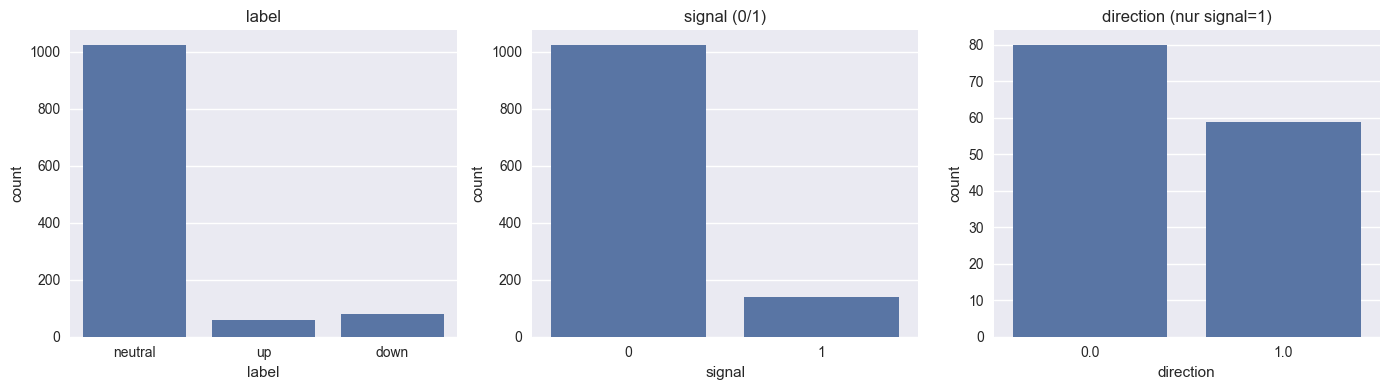

In [ ]:
print("Label-Verteilung (neutral/up/down):")
print(df["label"].value_counts())

print("\nSignal-Verteilung (0=neutral, 1=move):")
print(df["signal"].value_counts())

print("\nDirection (0=down, 1=up, ohne NaN):")
print(df["direction"].value_counts(dropna=True))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(x="label", data=df, ax=axes[0])
axes[0].set_title("label")

sns.countplot(x="signal", data=df, ax=axes[1])
axes[1].set_title("signal (0/1)")

sns.countplot(x="direction", data=df[df["signal"] == 1], ax=axes[2])
axes[2].set_title("direction (nur signal=1)")

plt.tight_layout()
plt.show()


## 3. Zeitliche Train/Val/Test‑Splits

Um Data Leakage zu vermeiden, werden die Daten **chronologisch** aufgeteilt:

- **Test-Split**: alle Daten ab dem 1. Januar 2025.
- **Train+Validation**: alle Daten von 2020 bis Ende 2024, darin nochmal 80 % Train / 20 % Val.

So sieht das Modell den Testzeitraum beim Training nicht und wir erhalten eine realistische Out‑of‑Sample‑Bewertung.


In [ ]:
# Test ab 2025-01-01, 80/20-Split innerhalb 2020–2024
splits = split_train_val_test(df, pd.to_datetime("2025-01-01"), train_frac_within_pretest=0.8)

for name, split_df in splits.items():
    print(f"{name}: {split_df['date'].min().date()} → {split_df['date'].max().date()} (n={len(split_df)})")


train: 2020-04-14 → 2024-04-09 (n=756)
val: 2024-04-10 → 2024-12-31 (n=189)
test: 2025-01-02 → 2025-11-05 (n=218)


## 4. Stufe 1 – Signal‑Modell (neutral vs move)

In dieser Stufe trainiere ich ein Binary‑XGBoost‑Modell auf:

- Ziel: `signal` (0 = neutral, 1 = Bewegung up/down)
- Features: News‑Sentiment + Volatilität + Schatten + Kalender (`FEATURE_COLS`)

Wegen der starken Klassenungleichverteilung verwende ich `scale_pos_weight ≈ N_neg / N_pos`
und Early Stopping auf dem Validierungs‑Split.


In [ ]:
# Zielvariablen
y_train_signal = build_signal_targets(splits["train"])
y_val_signal = build_signal_targets(splits["val"])
y_test_signal = build_signal_targets(splits["test"])

X_train_signal = splits["train"][FEATURE_COLS]
X_val_signal = splits["val"][FEATURE_COLS]
X_test_signal = splits["test"][FEATURE_COLS]

model_signal = train_xgb_binary(
    X_train_signal, y_train_signal,
    X_val_signal, y_val_signal
)

model_signal


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 5. Stufe 1 – Qualität des Signal‑Modells

Hier werte ich das Signal‑Modell für Train/Val/Test aus:

- Accuracy,
- Confusion‑Matrix,
- Classification‑Report (Precision, Recall, F1).

Besonders wichtig sind Precision und Recall der Klasse `1` (move).



=== TRAIN (SIGNAL) ===
Accuracy: 0.937
Classification report:
              precision    recall  f1-score   support

           0      0.998     0.930     0.963       669
           1      0.647     0.989     0.782        87

    accuracy                          0.937       756
   macro avg      0.823     0.959     0.872       756
weighted avg      0.958     0.937     0.942       756



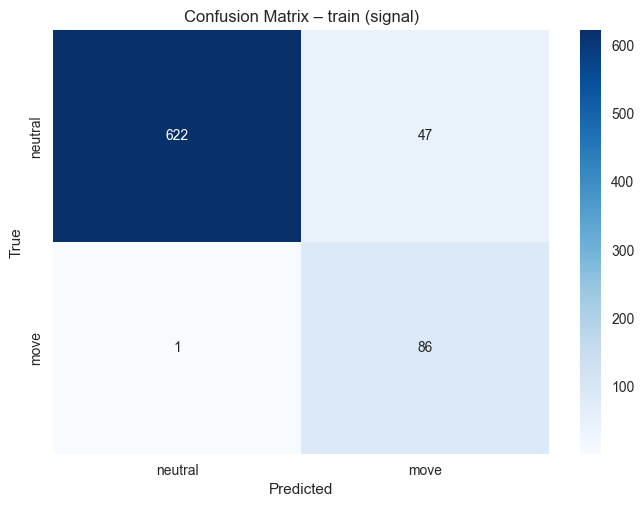


=== VAL (SIGNAL) ===
Accuracy: 0.815
Classification report:
              precision    recall  f1-score   support

           0      0.850     0.950     0.897       161
           1      0.111     0.036     0.054        28

    accuracy                          0.815       189
   macro avg      0.481     0.493     0.476       189
weighted avg      0.741     0.815     0.772       189



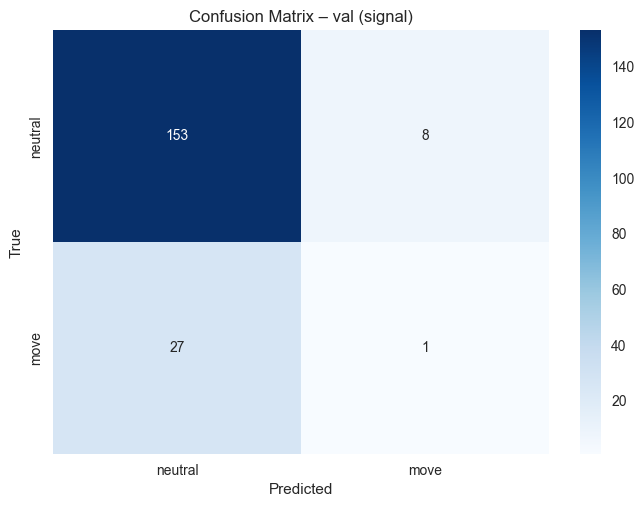


=== TEST (SIGNAL) ===
Accuracy: 0.803
Classification report:
              precision    recall  f1-score   support

           0      0.899     0.876     0.888       194
           1      0.172     0.208     0.189        24

    accuracy                          0.803       218
   macro avg      0.536     0.542     0.538       218
weighted avg      0.819     0.803     0.811       218



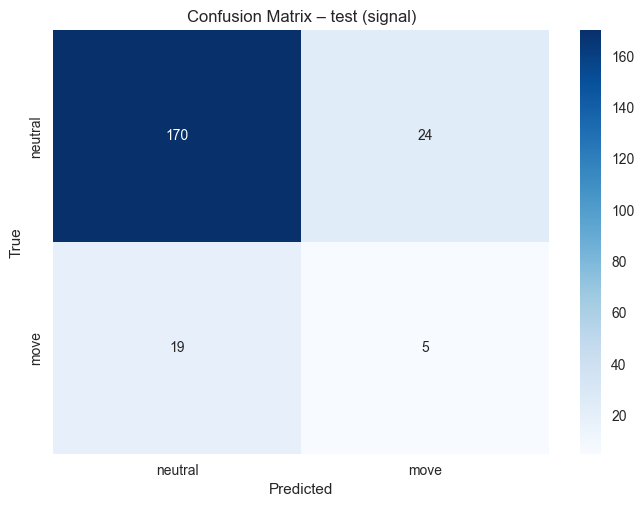

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def eval_and_plot(name, model, X, y_true):
    if len(X) == 0:
        print(f"[warn] {name} ist leer.")
        return
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name.upper()} ===")
    print(f"Accuracy: {acc:.3f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["neutral","move"],
                yticklabels=["neutral","move"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

eval_and_plot("train (signal)", model_signal, X_train_signal, y_train_signal)
eval_and_plot("val (signal)", model_signal, X_val_signal, y_val_signal)
eval_and_plot("test (signal)", model_signal, X_test_signal, y_test_signal)


# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"])
X_val_dir, y_val_dir = build_direction_targets(splits["val"])
X_test_dir, y_test_dir = build_direction_targets(splits["test"])

# Hier bewusst kein Class-Weighting (scale_pos_weight=1.0)
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

model_dir



=== TRAIN (DIRECTION) ===
Accuracy: 1.000
Classification report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        49
           1      1.000     1.000     1.000        38

    accuracy                          1.000        87
   macro avg      1.000     1.000     1.000        87
weighted avg      1.000     1.000     1.000        87



/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


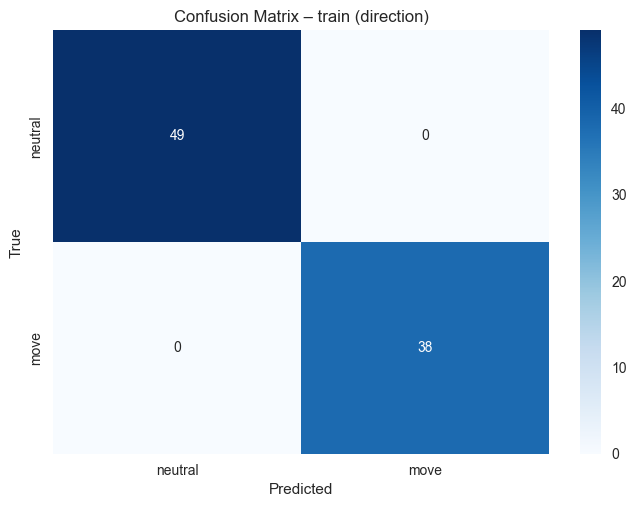


=== VAL (DIRECTION) ===
Accuracy: 0.893
Classification report:
              precision    recall  f1-score   support

           0      0.938     0.882     0.909        17
           1      0.833     0.909     0.870        11

    accuracy                          0.893        28
   macro avg      0.885     0.896     0.889        28
weighted avg      0.897     0.893     0.894        28



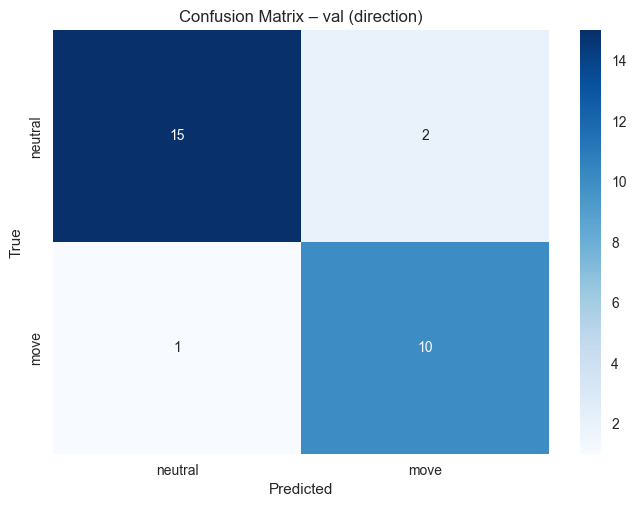


=== TEST (DIRECTION) ===
Accuracy: 0.750
Classification report:
              precision    recall  f1-score   support

           0      0.786     0.786     0.786        14
           1      0.700     0.700     0.700        10

    accuracy                          0.750        24
   macro avg      0.743     0.743     0.743        24
weighted avg      0.750     0.750     0.750        24



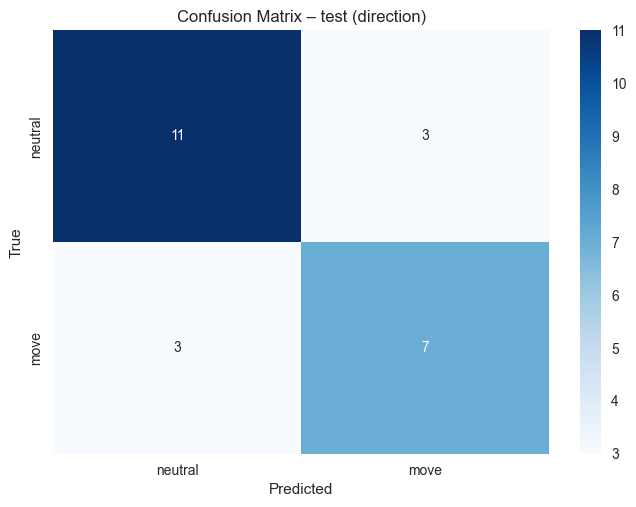

In [ ]:
# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"])
X_val_dir, y_val_dir = build_direction_targets(splits["val"])
X_test_dir, y_test_dir = build_direction_targets(splits["test"])

# Kein Class-Weighting nötig, Klassen relativ ausgeglichen → scale_pos_weight=1.0
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

eval_and_plot("train (direction)", model_dir, X_train_dir, y_train_dir)
eval_and_plot("val (direction)", model_dir, X_val_dir, y_val_dir)
eval_and_plot("test (direction)", model_dir, X_test_dir, y_test_dir)


## 8. Feature‑Importance

Um besser zu verstehen, welche Merkmale die Modelle tatsächlich nutzen, schaue ich mir
die Feature‑Importances der beiden XGBoost‑Modelle an:

- **Signal‑Modell** (neutral vs move): Welche Kombination aus News‑Sentiment, Volatilität,
  Schatten und Kalender ist wichtig, um Tage mit Bewegungen von neutralen Tagen zu unterscheiden?
- **Richtungs‑Modell** (up vs down): Welche Features helfen dabei, die Richtung einer Bewegung
  vorherzusagen, sobald ein Signal erkannt wurde?

Die Balkendiagramme sortieren die Features nach absteigender Wichtigkeit, basierend auf
den vom Modell gelernten Splits.


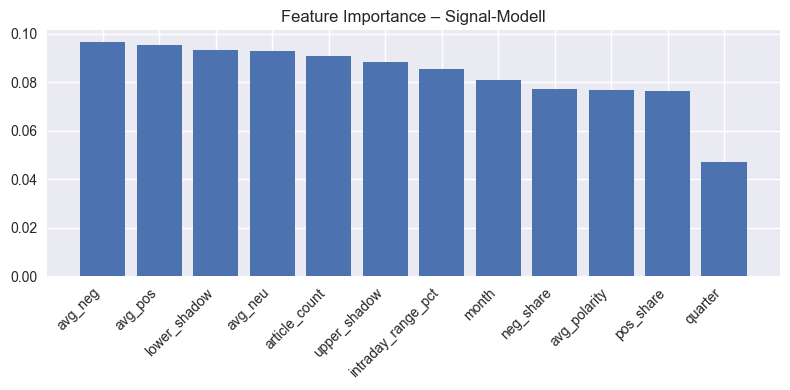

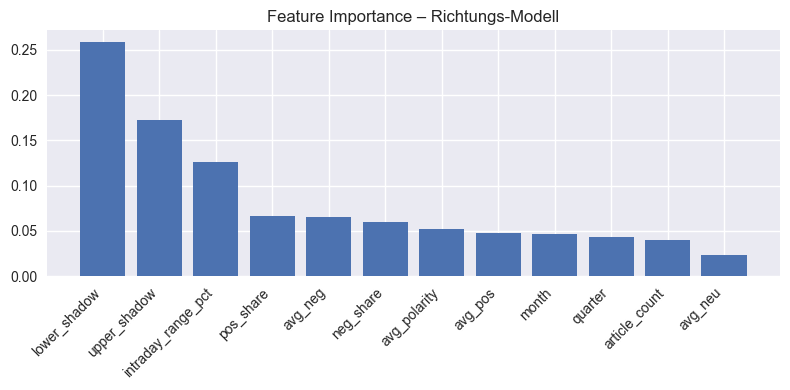

In [ ]:
import numpy as np

def plot_feature_importance(model, title):
    importance = model.feature_importances_
    order = np.argsort(importance)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(order)), importance[order])
    plt.xticks(range(len(order)),
               [FEATURE_COLS[i] for i in order],
               rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_signal, "Feature Importance – Signal-Modell")
plot_feature_importance(model_dir, "Feature Importance – Richtungs-Modell")


## 9. Kombinierte 3‑Klassen‑Auswertung (neutral / up / down)

Zum Schluss kombiniere ich beide Stufen zu einem finalen 3‑Klassen‑Output:

1. Das Signal‑Modell entscheidet für jeden Test‑Tag:
   - `signal = 0` → endgültiges Label = `neutral`
   - `signal = 1` → es liegt eine Bewegung vor (`move`)
2. Nur wenn `signal = 1`, wird das Richtungs‑Modell aufgerufen:
   - `direction = 1` → endgültiges Label = `up`
   - `direction = 0` → endgültiges Label = `down`

Aus diesen beiden Modellen baue ich ein kombiniertes Label (`neutral`/`up`/`down`) und
vergleiche es mit der wahren `label`‑Spalte im Testzeitraum ab 2025. Die 3‑Klassen‑Confusion‑Matrix
und der Classification‑Report zeigen, wie gut das Gesamtsystem neutrale Tage von Bewegungen
und die Richtung der Bewegungen unterscheidet.


3-Klassen-Confusion-Matrix (rows=true, cols=pred):


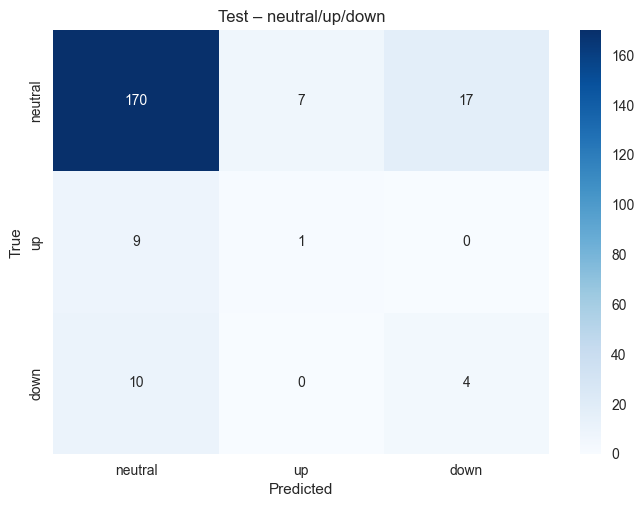


3-Klassen-Report:
              precision    recall  f1-score   support

        down      0.190     0.286     0.229        14
     neutral      0.899     0.876     0.888       194
          up      0.125     0.100     0.111        10

    accuracy                          0.803       218
   macro avg      0.405     0.421     0.409       218
weighted avg      0.818     0.803     0.810       218



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

X_test_all = splits["test"][FEATURE_COLS]

signal_pred = (model_signal.predict_proba(X_test_all)[:, 1] >= 0.5).astype(int)
dir_pred = (model_dir.predict_proba(X_test_all)[:, 1] >= 0.5).astype(int)

combined_pred = np.where(
    signal_pred == 0,
    "neutral",
    np.where(dir_pred == 1, "up", "down"),
)
combined_true = splits["test"]["label"].to_numpy()

print("3-Klassen-Confusion-Matrix (rows=true, cols=pred):")
cm3 = confusion_matrix(combined_true, combined_pred, labels=["neutral","up","down"])
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neutral","up","down"],
            yticklabels=["neutral","up","down"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test – neutral/up/down")
plt.show()

print("\n3-Klassen-Report:")
print(classification_report(combined_true, combined_pred, digits=3))


## 10. Baseline-Ergebnisse speichern (v0)

Bevor ich weitere Experimente (z.B. andere Thresholds oder geänderte Label-Logik) durchführe,
möchte ich den aktuellen Stand des Zwei-Stufen-Modells festhalten.

In dieser Zelle speichere ich:

- die wichtigsten Hyperparameter / Einstellungen (Label-Logik, Features, Splits),
- die Metriken für das Signal-Modell (Train/Val/Test, Threshold = 0.5),
- die Metriken für das Richtungs-Modell (Train/Val/Test, Threshold = 0.5),
- die 3‑Klassen-Auswertung (`neutral` / `up` / `down`) auf dem Test-Split.

Alles wird als eine JSON-Datei unter `../results/two_stage_v0_h4_thr1pct_strict.json` abgelegt,
sodass ich die Baseline später leicht mit neuen Varianten vergleichen kann.


In [ ]:
from pathlib import Path
import json
from sklearn.metrics import classification_report, confusion_matrix

# Ordner für Ergebnisse anlegen (relativ zum Notebook-Ordner)
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

# Ausgabedatei für diese Baseline-Konfiguration.
# Name enthält die wichtigsten Label-Parameter:
# - two_stage_v0: erste Version unseres Zwei-Stufen-Modells
# - h4: horizon_days = 4
# - thr1pct: ±1 % Lookahead-Schwellen
# - strict: strenge Monotonie-Bedingung
out_path = results_dir / "two_stage_v0_h4_thr1pct_strict.json"


def binary_metrics_dict(y_true, y_prob, threshold, target_names):
    """
    Hilfsfunktion, die für ein binäres Modell die wichtigsten Metriken
    in ein Dictionary schreibt.

    Parameter:
    - y_true: true Labels (0/1)
    - y_prob: vorhergesagte Wahrscheinlichkeit für Klasse 1 (shape: [n_samples])
    - threshold: Entscheidungsgrenze, ab der wir 1 vorhersagen
    - target_names: Namen der beiden Klassen, z.B. ["neutral", "move"]

    Rückgabe:
    - dict mit threshold, classification_report (als dict) und confusion_matrix (als Liste)
    """
    # Binäre Vorhersage aus den Wahrscheinlichkeiten ableiten
    y_pred = (y_prob >= threshold).astype(int)

    # Classification-Report in ein dict konvertieren (für JSON geeignet)
    report = classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        output_dict=True,
        digits=3,
    )

    # Confusion-Matrix als normale Python-Liste speichern
    cm = confusion_matrix(y_true, y_pred).tolist()

    return {
        "threshold": float(threshold),
        "report": report,
        "confusion_matrix": cm,
    }


# ---------------- Signal-Modell: Metriken für alle Splits ---------------- #

# Wahrscheinlichkeiten für Klasse 1 (move) je Split
probs_train_signal = model_signal.predict_proba(X_train_signal)[:, 1]
probs_val_signal = model_signal.predict_proba(X_val_signal)[:, 1]
probs_test_signal = model_signal.predict_proba(X_test_signal)[:, 1]

signal_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_signal,
        y_prob=probs_train_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_signal,
        y_prob=probs_val_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_signal,
        y_prob=probs_test_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
}


# ---------------- Richtungs-Modell: Metriken für alle Splits ------------- #

# Wahrscheinlichkeiten für Klasse 1 (up) je Split
probs_train_dir = model_dir.predict_proba(X_train_dir)[:, 1]
probs_val_dir = model_dir.predict_proba(X_val_dir)[:, 1]
probs_test_dir = model_dir.predict_proba(X_test_dir)[:, 1]

direction_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_dir,
        y_prob=probs_train_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_dir,
        y_prob=probs_val_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_dir,
        y_prob=probs_test_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
}


# ---------------- Kombinierte 3-Klassen-Auswertung auf Test -------------- #

# Für die kombinierte Auswertung verwenden wir alle Test-Tage (auch neutral)
X_test_all = splits["test"][FEATURE_COLS]

# Schritt 1: Signal-Vorhersage (0=neutral, 1=move)
signal_prob_test = model_signal.predict_proba(X_test_all)[:, 1]
signal_pred_test = (signal_prob_test >= 0.5).astype(int)

# Schritt 2: Richtungs-Vorhersage (nur relevant, wenn signal_pred_test == 1)
dir_prob_test = model_dir.predict_proba(X_test_all)[:, 1]
dir_pred_test = (dir_prob_test >= 0.5).astype(int)

# Endgültiges Label kombinieren:
# - wenn signal=0 → "neutral"
# - wenn signal=1 und direction=1 → "up"
# - wenn signal=1 und direction=0 → "down"
combined_pred = np.where(
    signal_pred_test == 0,
    "neutral",
    np.where(dir_pred_test == 1, "up", "down"),
)
combined_true = splits["test"]["label"].to_numpy()

combined_report = classification_report(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
    output_dict=True,
    digits=3,
)
combined_cm = confusion_matrix(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
).tolist()


# ---------------- Alles zusammen als JSON speichern --------------------- #

results = {
    "config": {
        # Wichtige Label-Parameter (Stand dieser Baseline)
        "horizon_days": 4,
        "up_threshold": 0.01,
        "down_threshold": -0.01,
        "strict_monotonic": True,
        # Meta-Infos zum Datensatz
        "dataset_path": str(dataset_path),
        "feature_cols": FEATURE_COLS,
        "test_start": "2025-01-01",
        "train_frac_within_pretest": 0.8,
    },
    "signal": signal_metrics,
    "direction": direction_metrics,
    "combined_test": {
        "report": combined_report,
        "confusion_matrix": combined_cm,
        "labels": ["neutral", "up", "down"],
    },
}

with open(out_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Baseline-Ergebnisse gespeichert unter: {out_path}")


Baseline-Ergebnisse gespeichert unter: ../results/two_stage_v0_h4_thr1pct_strict.json


## 11. Threshold-Tuning für das Signal-Modell

Bisher verwende ich für das Signal-Modell (neutral vs move) einen festen Threshold von 0.5:

- `P(move) >= 0.5` → Vorhersage = `move`
- `P(move) < 0.5` → Vorhersage = `neutral`

Aufgrund der starken Klassenungleichverteilung (sehr wenige `move`-Tage) kann es sinnvoll sein,
den Threshold anzupassen. Ziel:

- **hohe Precision für `signal=1` (move)**,
- aber der **Recall für `signal=1`** soll nicht komplett zusammenbrechen.

Dazu scanne ich auf dem Validierungs-Split mehrere Thresholds und berechne für die Klasse `move`:

- Precision
- Recall
- F1-Score
- F0.5-Score (β = 0.5 → Precision etwas wichtiger als Recall)

Anhand dieser Tabelle kann ich später einen Threshold auswählen, der gut zu meinen Zielen passt.


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Wahrscheinlichkeiten für Klasse 1 (move) auf dem Validierungs-Split
probs_val_signal = model_signal.predict_proba(X_val_signal)[:, 1]

# Kandidaten-Thresholds, die wir testen wollen
candidate_thresholds = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15]

rows = []

for t in candidate_thresholds:
    # Binäre Vorhersage aus den Wahrscheinlichkeiten ableiten
    y_pred = (probs_val_signal >= t).astype(int)

    # precision_recall_fscore_support liefert pro Klasse (0 und 1) die Kennzahlen
    # Wir interessieren uns hier speziell für Klasse 1 = "move"
    prec, rec, f1, support = precision_recall_fscore_support(
        y_val_signal,
        y_pred,
        average=None,       # getrennt nach Klassen
        labels=[0, 1],      # Reihenfolge: 0 = neutral, 1 = move
        zero_division=0,    # falls keine positive Vorhersage gemacht wird
    )

    # Kennzahlen für Klasse 1 (Index 1)
    p_move = prec[1]
    r_move = rec[1]
    f1_move = f1[1]
    s_move = support[1]

    # F_beta mit Beta = 0.5 (Precision etwas höher gewichtet als Recall)
    beta = 0.5
    if p_move == 0 and r_move == 0:
        f_beta = 0.0
    else:
        f_beta = (1 + beta**2) * (p_move * r_move) / (beta**2 * p_move + r_move)

    rows.append(
        {
            "threshold": t,
            "precision_move": p_move,
            "recall_move": r_move,
            "f1_move": f1_move,
            "f0.5_move": f_beta,
            "support_move": s_move,
        }
    )

# Ergebnisse als DataFrame darstellen und nach F0.5 sortieren
thr_df = pd.DataFrame(rows).sort_values("threshold", ascending=False)
thr_df


,threshold,precision_move,recall_move,f1_move,f0.5_move,support_move
0,0.50,0.111111,0.035714,0.054054,0.078125,28
1,0.40,0.076923,0.071429,0.074074,0.075758,28
2,0.35,0.121951,0.178571,0.144928,0.130208,28
3,0.30,0.163636,0.321429,0.216867,0.181452,28
4,0.25,0.162162,0.428571,0.235294,0.185185,28
5,0.20,0.156250,0.535714,0.241935,0.182039,28
6,0.15,0.139344,0.607143,0.226667,0.164729,28


## 12. Labels und Trainingsdatensatz nach Anpassung prüfen

Nachdem ich die Label-Logik angepasst und im Terminal

- `python3 -m src.data.label_eurusd`
- `python3 -m src.data.build_training_set`

ausgeführt habe, lade ich den aktualisierten Trainingsdatensatz erneut.

Hier kontrolliere ich:

- die Verteilung der endgültigen 3-Klassen-Labels `label` (`neutral`, `up`, `down`),
- die Verteilung von `signal` (0 = neutral, 1 = Bewegung),
- die Verteilung von `direction` (0 = down, 1 = up, nur für `signal = 1`).

So sehe ich, ob die gelockerte Label-Logik tatsächlich mehr `move`-Tage erzeugt
und ob das Verhältnis von `up` zu `down` im sinnvollen Bereich liegt.


In [ ]:
import pandas as pd

# Aktualisierten Trainingsdatensatz einlesen.
# Wir verwenden project_root, das in einer früheren Zelle so gesetzt wurde:
#   project_root = Path("..").resolve().parent
# Dadurch sind wir unabhängig davon, in welchem Unterordner das Notebook liegt.
train = pd.read_csv(
    project_root / "data/processed/datasets/eurusd_news_training.csv",
    parse_dates=["date"],  # 'date' direkt als Datumsobjekt einlesen
)

# Verteilung der drei Hauptlabels:
# - 'neutral'
# - 'up'
# - 'down'
print("Label-Verteilung (label):")
print(train["label"].value_counts())
print()

# Verteilung des Signal-Labels:
# - 0 = neutral
# - 1 = Bewegung (up oder down)
print("Signal-Verteilung (signal):")
print(train["signal"].value_counts())
print()

# Verteilung der Richtungs-Labels:
# - 0 = down
# - 1 = up
# NaN = neutral (wird mit dropna=True ignoriert)
print("Richtungs-Verteilung (direction, ohne NaN):")
print(train["direction"].value_counts(dropna=True))


Label-Verteilung (label):
label
neutral    1024
down         80
up           59
Name: count, dtype: int64

Signal-Verteilung (signal):
signal
0    1024
1     139
Name: count, dtype: int64

Richtungs-Verteilung (direction, ohne NaN):
direction
0.0    80
1.0    59
Name: count, dtype: int64


In [ ]:
from pathlib import Path

# Aktuelles Arbeitsverzeichnis des Notebooks
cwd = Path.cwd()
print("Aktuelles Arbeitsverzeichnis:", cwd)

# Heuristik: wir laufen nach oben, bis ein Ordner "data" existiert
project_root = cwd
while not (project_root / "data").is_dir():
    project_root = project_root.parent

print("Erkannte Projektwurzel:", project_root)


Aktuelles Arbeitsverzeichnis: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/notebooks
Erkannte Projektwurzel: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Optional: etwas schönere Standard-Optik
plt.style.use("seaborn-v0_8")

# EURUSD-Labels laden (inkl. lookahead_return und label)
# Wir verwenden project_root, das in der vorherigen Zelle ermittelt wurde.
labels = pd.read_csv(
    project_root / "data/processed/fx/eurusd_labels.csv",
    parse_dates=["Date"],  # 'Date' direkt als Datumsobjekt einlesen
)

# Ab 2020 filtern, weil es ab da News-Features gibt
labels_2020 = labels[labels["Date"] >= "2020-01-01"].copy()

labels_2020.head()


,Date,Close,High,Low,Open,Volume,lookahead_return,label
1301,2020-01-01,1.122083,1.122838,1.115947,1.122083,0,-0.002035,neutral
1302,2020-01-02,1.122083,1.122712,1.116682,1.121894,0,-0.005890,neutral
1303,2020-01-03,1.117144,1.118068,1.112570,1.117081,0,-0.005212,neutral
1304,2020-01-06,1.116196,1.120825,1.115810,1.116246,0,-0.004556,neutral
1305,2020-01-07,1.119799,1.119946,1.113487,1.119583,0,-0.007263,neutral


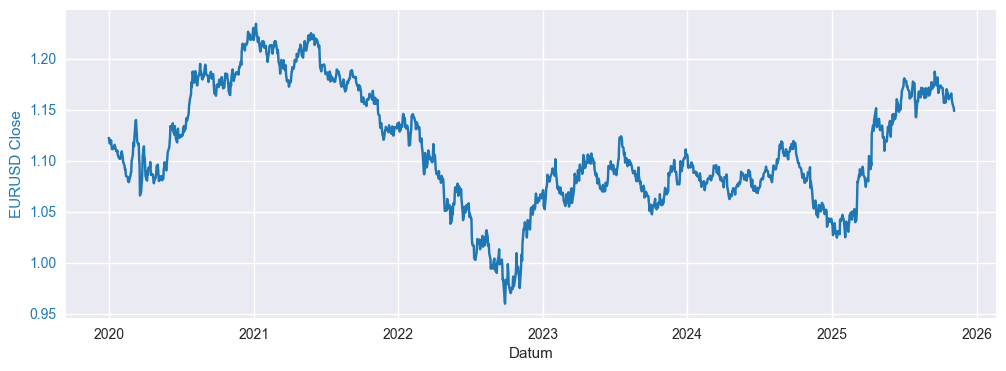

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# 1. Achse: EURUSD-Schlusskurs
ax1.plot(labels_2020["Date"], labels_2020["Close"],
         color="tab:blue", label="Close")
ax1.set_xlabel("Datum")
ax1.set_ylabel("EURUSD Close", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# # 2. Achse: Lookahead-Return über 4 Tage
# ax2 = ax1.twinx()
# ax2.plot(labels_2020["Date"], labels_2020["lookahead_return"],
# color="tab:orange", label="4-Tage-Return")
# ax2.axhline(0.01, color="green", linestyle="--", alpha=0.5, label="+1% Schwelle")
# ax2.axhline(-0.01, color="red", linestyle="--", alpha=0.5, label="-1% Schwelle")
# ax2.set_ylabel("Lookahead-Return (4 Tage)", color="tab:orange")
# ax2.tick_params(axis="y", labelcolor="tab:orange")

# # Gemeinsame Legende
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# plt.title("EURUSD ab 2020 – Kurs & 4-Tage-Return")
# plt.tight_layout()
# plt.show()


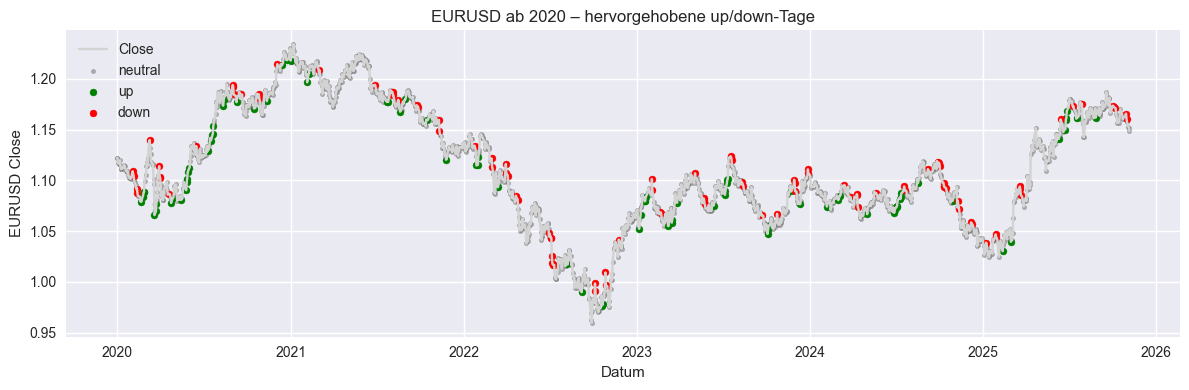

In [ ]:
mask_up = labels_2020["label"] == "up"
mask_down = labels_2020["label"] == "down"
mask_neutral = labels_2020["label"] == "neutral"

fig, ax = plt.subplots(figsize=(12, 4))

# Kurslinie
ax.plot(labels_2020["Date"], labels_2020["Close"],
        color="lightgray", label="Close")

# Punkte für neutral / up / down
ax.scatter(labels_2020.loc[mask_neutral, "Date"],
           labels_2020.loc[mask_neutral, "Close"],
           color="gray", s=10, alpha=0.6, label="neutral")

ax.scatter(labels_2020.loc[mask_up, "Date"],
           labels_2020.loc[mask_up, "Close"],
           color="green", s=25, label="up")

ax.scatter(labels_2020.loc[mask_down, "Date"],
           labels_2020.loc[mask_down, "Close"],
           color="red", s=25, label="down")

ax.set_xlabel("Datum")
ax.set_ylabel("EURUSD Close")
ax.set_title("EURUSD ab 2020 – hervorgehobene up/down-Tage")
ax.legend()
plt.tight_layout()
plt.show()


## 13. Oversampling der `move`-Klasse im Trainingssplit (Signal-Modell)

Auch mit der gelockerten Label-Logik (4 Tage, ±0.5 %, streng monoton) bleibt die Klasse
`signal = 1` (Bewegung) im Trainingssplit unterrepräsentiert.

Um dem Modell mehr Beispiele für Bewegungen zu geben, oversample ich die `move`-Zeilen
**nur im Trainingssplit**:

- jede Zeile mit `signal = 1` wird mehrfach dupliziert,
- Validation- und Test-Splits bleiben unverändert (kein Oversampling), damit die Auswertung
  realistisch bleibt.

Anschließend trainiere ich ein neues Signal-Modell (`model_signal_os`) auf diesem
oversampleten Trainingssplit und vergleiche Train/Val/Test erneut.


In [11]:
# Kopie des Trainingssplits für das Signal-Modell.
# 'splits["train"]' enthält alle Features + 'signal' + 'direction'.
train_signal_df = splits["train"].copy()

# Positive Beispiele: alle Tage mit Bewegung (signal == 1).
train_pos = train_signal_df[train_signal_df["signal"] == 1]

print("Vor Oversampling:")
print(train_signal_df["signal"].value_counts())

# Faktor, wie stark wir die positiven Beispiele vervielfachen wollen.
# Beispiel: oversample_factor = 3 → ca. dreifache Anzahl Positiv-Beispiele.
oversample_factor = 3

# Zusätzliche Kopien der Positiv-Beispiele erzeugen:
# - sample(..., replace=True) = Ziehen mit Zurücklegen
# - frac = oversample_factor - 1: so viele zusätzliche Kopien wollen wir erzeugen.
train_pos_extra = train_pos.sample(
    frac=oversample_factor - 1,
    replace=True,
    random_state=42,
)

# Original-Train + zusätzliche Positiv-Beispiele zusammenführen.
train_oversampled = pd.concat(
    [train_signal_df, train_pos_extra],
    ignore_index=True,
)

# Optional: Reihenfolge mischen (für Bäume nicht kritisch, aber schadet nicht).
train_oversampled = train_oversampled.sample(
    frac=1.0,
    random_state=42,
).reset_index(drop=True)

print("\nNach Oversampling:")
print(train_oversampled["signal"].value_counts())

# Features und Zielvariable für das neue Signal-Modell definieren.
X_train_signal_os = train_oversampled[FEATURE_COLS]
y_train_signal_os = train_oversampled["signal"].astype(int).to_numpy()

# Neues Signal-Modell auf dem oversampleten Trainingssplit.
# Wichtig: scale_pos_weight = 1.0, da wir das Ungleichgewicht bereits
# durch Oversampling reduziert haben.
model_signal_os = train_xgb_binary(
    X_train_signal_os,
    y_train_signal_os,
    X_val_signal,   # Validation bleibt unverändert
    y_val_signal,
    scale_pos_weight=1.0,
)

model_signal_os


NameError: name 'splits' is not defined

### 13.1 Vergleich: ursprüngliches vs. oversampletes Signal-Modell

Im nächsten Schritt vergleiche ich das ursprüngliche Signal-Modell (`model_signal`)
mit dem neuen Modell (`model_signal_os`), das auf einem oversampleten Trainingssplit
trainiert wurde.

Ich verwende die gleiche Auswertungsfunktion wie zuvor (Accuracy, Confusion-Matrix,
Classification-Report), aber setze jetzt `model_signal_os` ein.


In [ ]:
# Auswertung des neuen, oversampleten Signal-Modells
eval_and_plot("train (oversampled)", model_signal_os, X_train_signal_os, y_train_signal_os)
eval_and_plot("val (oversampled)", model_signal_os, X_val_signal, y_val_signal)
eval_and_plot("test (oversampled)", model_signal_os, X_test_signal, y_test_signal)
